# Proyect 1: Airbnb behaviour analysis in CDMX


## Team Members

* Ernesto López Centeno
* Estefanía González Zavala
* Miztli Deneb Aguirre Montealegre


## Hypothesis

1. Location influences Airbnb quantity in CDMX.
2. Location influences Airbnb price in CDMX.
3. Crime influences Airbnb price in CDMX.
4. Poverty influences Airbnb price in CDMX
5. If someone owns more than one Airbnb the offer price will be lower

In [1]:
# Import dependencies
import pandas as pd
import scipy.stats as st
import matplotlib
import csv
import os
import gmaps
import matplotlib.pyplot as plt
import numpy as np
import requests
import json

# Import api keys
from api_keys import g_key

In [2]:
# Import the CSV file into a DataFrame
data_df = pd.read_csv("listings1.csv")
data_df = data_df.drop("neighbourhood_group", axis = 1)

# Drop empy-valued rows
data_df = data_df.dropna()

#data_df.head()

# Drop zero-priced Airbnbs
index_price = data_df[data_df["price"] == 0 ].index
for x in range(len(index_price)):
    data_df.drop(index_price[x], inplace = True)

#len(data_df)
#data_df.head()

## Location vs Availability Analysis


### Hypothesis

**Location influences Airbnb quantity in CDMX**

### Veredict

**True**
* The bar plot shows that, depending on the neighbourhood, quantity increases or decreases.
* Nicer/touristic neighbourhoods have more Airbnbs. 
* Cuauhtémoc is closer to downtown CDMX (Zócalo), and it includes nice-to-live areas like Condesa and Roma
* Miguel Hidalgo includes touristic places like Chapultepec and it has one of the best places to live in the city; Polanco.
* Benito Juárez includes fancy business areas, nice living places and is also close to Zócalo.

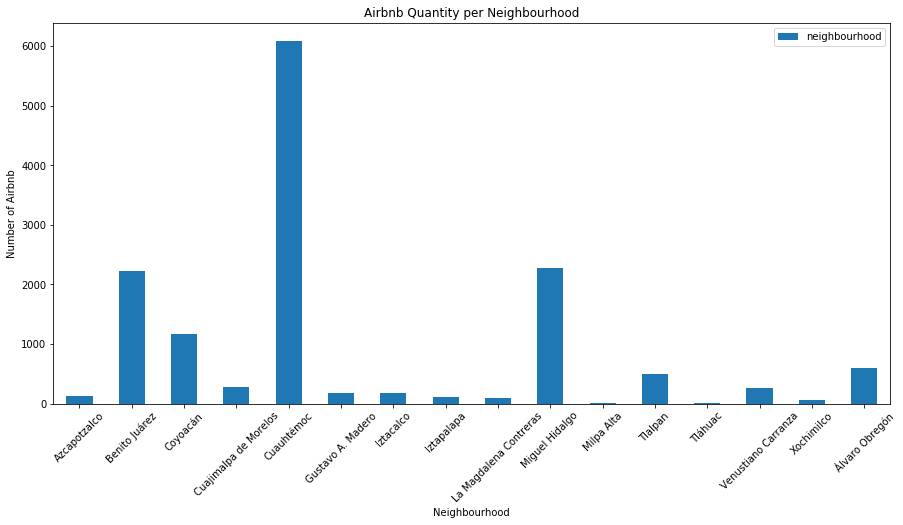

In [3]:
# Create a new frame based on the number of Airbnbs per neighbourhood (called Delegación)
neighbourhood = data_df["neighbourhood"].value_counts().to_frame()

# Sort the index alphabetically and bar-plot
neighbourhood.sort_index().plot(kind = "bar", figsize = (15, 7))

# Add title and labels
plt.title("Airbnb Quantity per Neighbourhood")
plt.xlabel("Neighbourhood")
plt.ylabel("Number of Airbnb")

# Rotate the x names
plt.xticks(rotation = 45)

# Display the plot
plt.show()

## Location vs Price Analysis


### Hypothesis

**Location influences Airbnb price in CDMX**

### Veredict

**True**
* The bar plot shows that, depending on the neighbourhood, mean price increases or decreases.
* The price heatmap gets hotter closer to fancy areas like Polanco, Chapultepec, Roma, Condesa and Zócalo.
* Nicer/touristic neighbourhoods have pricier Airbnbs.
* An area that comes to shine in the private room, in the second bar plot is Tláhuac, a site that includes a very touristic site called Xochimilco lake, which is famous for its boats called Trajineras.

**Special Findings**
* Coajimalpa de Morelos is a fast-growing, fancy neighbourhood, translating into a high demand for living places.
* From the first analysis, we can see that the Airbnb quantity for this area is low, which translates into a poor offer.
* A high demand with a low offer combines to make the best formula for sky-rocket prices, which can be seen in the overall mean pricing and room-type pricing plots.
* From the room-type pricing plot, we an see that it has the highest private room mean price, and second highest full Airbnb price.

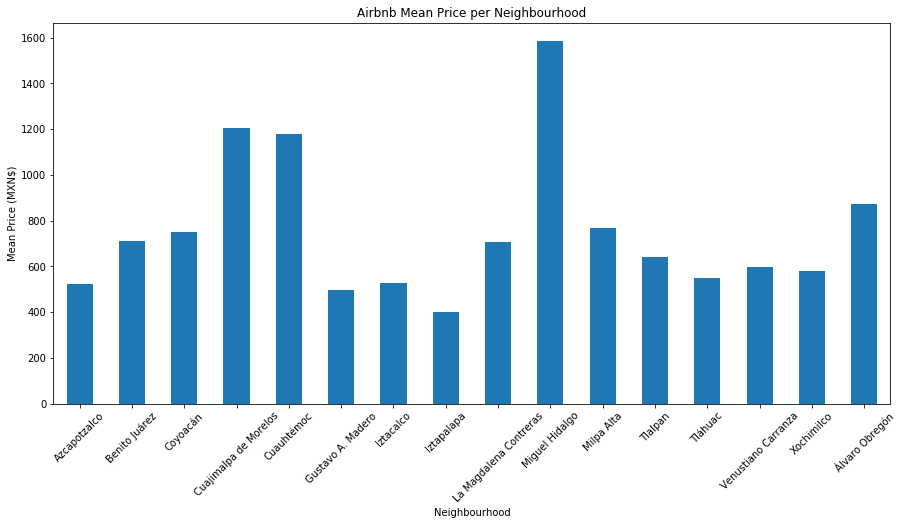

In [4]:
# Plot the mean price per neighbourhood
data_df.groupby(["neighbourhood"])["price"].mean().plot(kind = "bar", figsize = (15, 7))

# Add title and labels
plt.title("Airbnb Mean Price per Neighbourhood")
plt.xlabel("Neighbourhood")
plt.ylabel("Mean Price (MXN$)")

# Rotate the x names
plt.xticks(rotation = 45)

# Display the plot
plt.show()

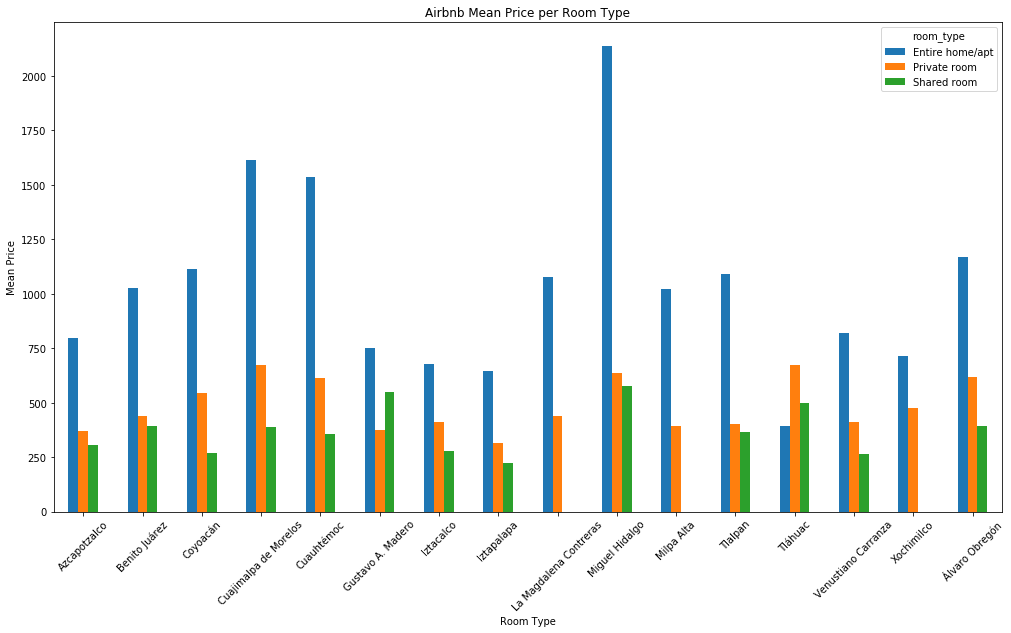

In [5]:
# Create a DataFrame for mean price per room type and neighbourhood
room_price = data_df.groupby(["neighbourhood", "room_type"])["price"].mean().unstack()

# Bar plot the DataFrame
room_price.plot(kind = "bar", figsize = (17,9))

# Add title and labels
plt.title("Airbnb Mean Price per Room Type")
plt.xlabel("Room Type")
plt.ylabel("Mean Price")

# Rotate x names
plt.xticks(rotation = 45)

# Display the plot
plt.show()

In [6]:
# Set locations, price and max intensity for the heatmap
locations = data_df[["latitude", "longitude"]]
price = data_df["price"]
max_int = data_df["price"].max()

In [7]:
# Plot Price heatmap
fig = gmaps.figure()

# Create a heat layer based on locations, price and max price
heat_l = gmaps.heatmap_layer(locations, weights = price, max_intensity = max_int, point_radius = 10)

# Add the heat layer
fig.add_layer(heat_l)

# Display the plot
fig

Figure(layout=FigureLayout(height='420px'))

## Location vs Crime Analysis


### Hypothesis

**Crime influences Airbnb price in CDMX**

### Veredict

**True, with two exceptions**
* The first scatter plot reveals a misleading conclusion that price and crime are directly proportional.
* After thoroughly checking the dataset, we found out that we have two neighbourhoods that have an uninfluenced mean price-crime relation. This two colonies were Miguel Hidalgo and Cuauhtémoc. As explained earlier, these are considered the two best neighbourhoods to live in CDMX, both for tourists and locals. This gives them the highest demand, thus their prices increase in spite of the high crime rates.
* After taking these two neighbourhoods out of the equatioin, we can see that, as crime decreases, mean prices increases.
* This means that crime has an inversely proportional relationship with price.

In [8]:
# Import the CSV file's selected columns into a DataFranme
delitos_df = pd.read_csv("delitos.csv", usecols = (['alcaldia_hechos', 'delito']))

# Set the DataFrame index
delitos_df.index = delitos_df["alcaldia_hechos"]

# Drop the column with neighbourhoods (it repeats in the index)
delitos_df = delitos_df.drop(columns = "alcaldia_hechos")

# Sort the DataFrame index alphabetically
delitos_df = delitos_df.sort_index()

# delitos_df.head()

In [9]:
# Rename the row to remove the spanish accent
neighbourhood = neighbourhood.rename({"Álvaro Obregón": "Alvaro Obregón"})

# Sort index alphabetically
neighbourhood = neighbourhood.sort_index()

# Create a new column counting the amount of insidences
neighbourhood["insidences"] = ""
for x in range(len(delitos_df)):
    neighbourhood["insidences"][x] = delitos_df["delito"][x]
# neighbourhood.head(16)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [10]:
# Create a DataFrame with neighbourhood and mean price
price = data_df.groupby(["neighbourhood"])["price"].mean().to_frame(name = "price")
price = price.sort_index()
neighbourhood["price"] = price["price"]
# neighbourhood.head(16)

The correlation between price and crimes is 0.01


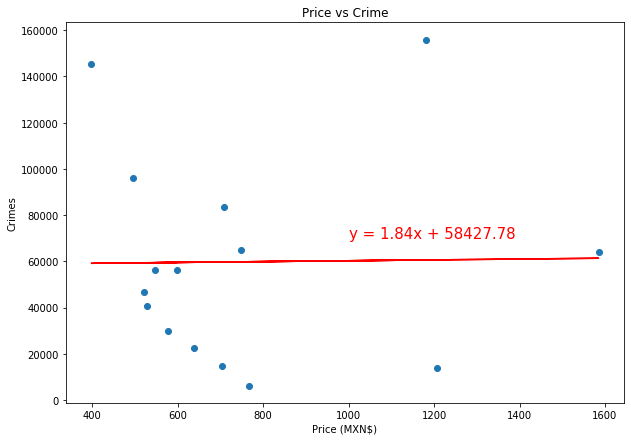

In [11]:
# Create a DataFrame from the three previous 
analysis_df = neighbourhood[["neighbourhood", "price", "insidences"]]

# Drop empty-valued rows
analysis_df = analysis_df.dropna(how = "any")
# analysis_df.head()

# Create a variable for crime and price as integer types
crime = analysis_df["insidences"].astype(int)
priced = analysis_df["price"].astype(int)

# Calculate the correlation coefficient and linear regression model for mouse weight and average tumor volume for the Capomulin regimen
correlation = st.pearsonr(priced, crime)

# Print the correlation coefficient
print(f'The correlation between price and crimes is {round(correlation[0], 2)}')

# Linear regression function, taking in as arguments the x and y lists, and returning the slope, the intercept
# the r-value, p-value and the stderr
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(priced, crime)

# Linear regression values, multiplying the x list value by the slope and adding the intercept
regress_values = priced*slope+intercept

# Line equation expressed as y = mx + b, where m is the slope and b is the intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2)) 

# Create a figure to plot on, set its size
fig6, ax6 = plt.subplots(figsize = (10, 7))

# Pyplot the weight-tumor volume scatter plot
plt.scatter(priced, crime)

# Plot the regression line and annotate its function in the (20, 38) interception
plt.plot(priced, regress_values, "r-")
plt.annotate(line_eq, (1000, 70000), fontsize = 15, color = "red")

# Add title and labels
plt.title("Price vs Crime")
plt.xlabel("Price (MXN$)")
plt.ylabel("Crimes")

# Display the plot in a tight layout
# plt.tight_layout()

# Show the plot
plt.show()

The correlation between price and crimes is -0.56


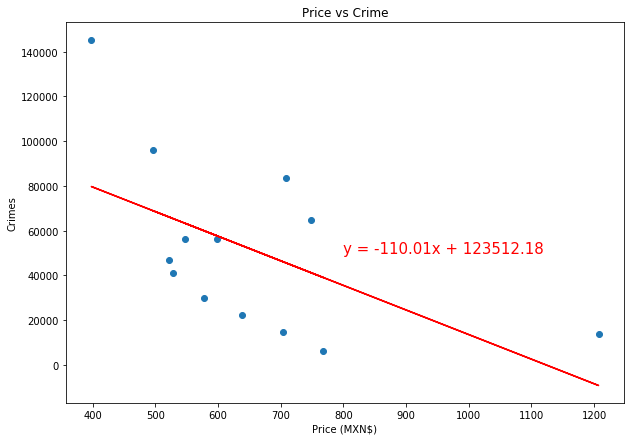

In [12]:
# Create a DataFrame based on the previous one, excludint two columns
analysis_df2 = analysis_df.drop(index = ["Miguel Hidalgo", "Cuauhtémoc"])
# analysis_df.head()

# Create new crime and price variables
crime2 = analysis_df2["insidences"].astype(int)
priced2 = analysis_df2["price"].astype(int)

# Calculate the correlation coefficient and linear regression model
correlation = st.pearsonr(priced2, crime2)

# Print the correlation coefficient
print(f'The correlation between price and crimes is {round(correlation[0], 2)}')

# Linear regression function, taking in as arguments the x and y lists, and returning the slope, the intercept
# the r-value, p-value and the stderr
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(priced2, crime2)

# Linear regression values, multiplying the x list value by the slope and adding the intercept
regress_values = priced2*slope+intercept

# Line equation expressed as y = mx + b, where m is the slope and b is the intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2)) 

# Create a figure to plot on, set its size
fig6, ax6 = plt.subplots(figsize = (10, 7))

# Pyplot the weight-tumor volume scatter plot
plt.scatter(priced2, crime2)

# Plot the regression line and annotate its function in the (20, 38) interception
plt.plot(priced2, regress_values, "r-")
plt.annotate(line_eq, (800, 50000), fontsize = 15, color = "red")

# Add title and labels
plt.title("Price vs Crime")
plt.xlabel("Price (MXN$)")
plt.ylabel("Crimes")

# Display the plot in a tight layout
# plt.tight_layout()

# Show the plot
plt.show()

In [13]:
# Import the CSV file into a DataFrame
crime_df = pd.read_csv("cdmx_crimenes.csv")

# Drop empty-valued rows
crime_df = crime_df.dropna(how = "any")

# Count crime incidences per latitudde and create a DataFrame
crime_df = crime_df.groupby(["latitud"])["longitud"].value_counts().to_frame(name = "count").sort_values(by = ["count"]).reset_index()

In [14]:
# Set locations, crime count and max intensity for the heatmap
location = crime_df[["latitud", "longitud"]]
count = crime_df["count"]
max_intense = crime_df["count"].max()

In [15]:
# Plot Price heatmap
fig = gmaps.figure()

# Create a heat layer
heat_2 = gmaps.heatmap_layer(location, weights = count, max_intensity = max_intense, point_radius = 5)

# Add the heat layer
fig.add_layer(heat_2)

# Display the plot
fig

Figure(layout=FigureLayout(height='420px'))

## Poverty vs Price Analysis


### Hypothesis

**Poverty influences Airbnb price in CDMX**

### Data notes
In this part of the analysis, we used the Mexico City's goverment data to get some insight about poverty indexes in the city and how they affect Airbnb prices. For this porpouses, we used the /Niveles Básicos Insatisfechos (NBI)/ index or Insatisfaed Basic Levels, which represents a weighted media in basic services for a good living. By getting a mean by /Alcaldia/ we get and idea of poverty levels in each of this places. So we can see if there's a relationship between these and Airbnb prices. We take the data from 2015 as the only one who was available. 


### Veredict
* Varely True.
* Although the regression line shows a Negative Linear Association which fits in our hyphotesis, the pearson correlation coefficient is -0.39, which indicates a weak correlation while not totally false. 
* The last is undestandable, if we take a look on the sacatter plot. The cheapest two Alcadias are the ones with high poverty levels, and the three more expensive Alcaldias are below poverty levels of 1000, but also the eleven remaining Alcaldias.  

In [16]:
#IMPORT DATASET FROM CDMX DATA
    #NBI Indice de desarrollo social en la ciudad de Mexico
    # A partir de los resultados en los ocho indicadores usados por Evalúa para medir el desarrollo social en la CDMX, 
    # se obtiene un índice global de Niveles Básicos Insatisfechos (NBI). El procedimiento es una media ponderada de 
    # las ocho dimensiones (Adecuación Sanitaria, Bienes Durables, Educación, Energía, Salud, Seguridad Social, Telefonía 
    # y Vivienda), utilizando como ponderadores los costos obtenidos en la Canasta Normativa de Satisfactores 
    # Esenciales (CNSE) completa.
    # FUENTE : https://datos.cdmx.gob.mx/explore/dataset/diagnostico-cdmx_2015_nbi/information/
herepath = os.path.dirname(os.path.abspath('__file__'))
NBI = os.path.join(herepath,'NewData','NBI Índice de Desarrollo Social en la cdmx_2015_nbi.csv')
NBI = pd.read_csv(NBI)
#NBI.head()

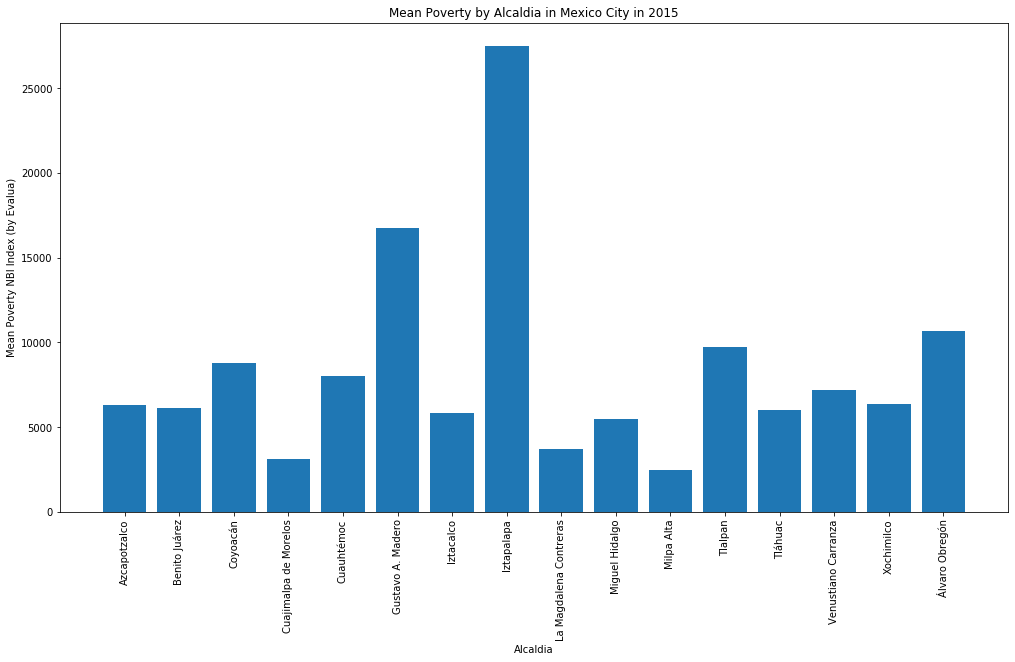

In [17]:
#To simplify we group the data by 'Alcaldia' and get the mean poverty by each of this locations. 
Pobreza = NBI.groupby(['NOMBRE'], as_index=False).mean()
#Then we take just one absolute value (named as 'total' in de the dataset) 
#And take a look on poverty levels in the city
plt.figure(figsize = (17,9))
plt.bar(Pobreza['NOMBRE'], Pobreza['total'])
plt.xticks(rotation = 90)
plt.title("Mean Poverty by Alcaldia in Mexico City in 2015")
plt.xlabel("Alcaldia")
plt.ylabel("Mean Poverty NBI Index (by Evalua)")
plt.show()

In [18]:
#Here we create a reduced data set grouped by Alcaldia and mean price
Price = data_df.groupby('neighbourhood', as_index = False)['price'].mean()
Price = pd.DataFrame(Price)
#We add the column 'poverty' from the total poverty index in the past dataset  
Price['poverty'] = Pobreza['total'].values


#First we checkout correlation between poverty and price 
correlation = st.pearsonr(Price['poverty'], Price['price'])
print(f'The correlation between price and poverty is {round(correlation[0], 2)}')
correlation2 = st.pearsonr(priced2, crime2)
print(f'The correlation between price and crimes is {round(correlation2[0], 2)}')
#Here we get a low correlation, and actually is bigger between crime and price


The correlation between price and poverty is -0.39
The correlation between price and crimes is -0.56


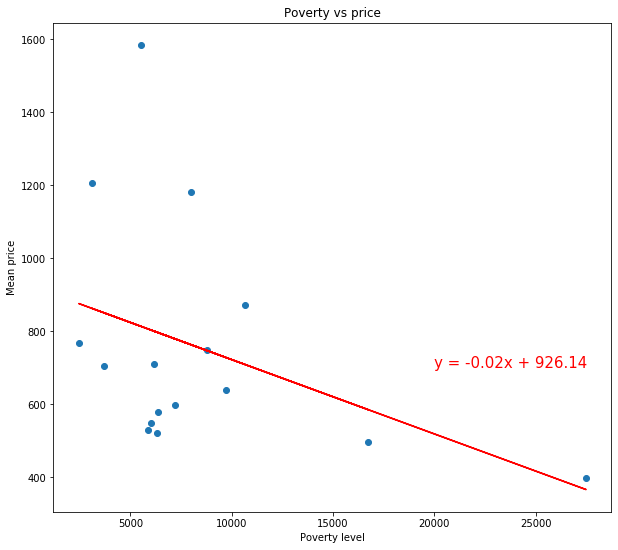

In [19]:
#Now we can create a Boxplot to explore any realtionship
#Also we calculate a regression line
from scipy.stats import linregress

x_values = Price['poverty']
y_values = Price['price']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.figure(figsize = (10,9))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20000, 700),fontsize=15,color="red")
plt.title('Poverty vs price')
plt.xlabel('Poverty level')
plt.ylabel('Mean price')
plt.show()


## Market Exploitation Analysis

### Hypothesis

**If someone owns more than one airbnb will offer lower prices**

### Veredict
* Mostly False
* The mean price between those who own one to four airbnbs have similar prices. But those who have 5 or more tend to offer higher prices. 
* The exception are the shared rooms that are usually cheaper with those who own more than 5 rooms. The reason should be that this kind of rooms are offered by hostels. But this fact isn't meaningful to our mayor conclusion as shared rooms represent just 1.5% of the hosting offer in Mexico City.


In [20]:
#THIS ADD THE COLUMN HOST'S NUMBER OF POSSESSIONS
data_df['ownersposessions'] = data_df.groupby('host_id')['host_id'].transform('count')
#data_df.head()

#Here we clasificate owners
#bins = [0,1,5,10,20,30,50]
#labels = ['Family-economy (1)', 'Aspirationist(2-5)', 'Professional(5-10)', 'Entrepreneur(10-20)', 'Capitalist(20-30)','Monopolist(30 or more)']


#We choose this beens because when we applied a boxplot to individual numbers such as 1,2,3,4, it was the number 
#five when the boxplot show us a difference between prices and airbnb's ownership.
bins = [0,1,5,50]
labels = ['Side Business(1)', 'Aspirationist(2-4)', 'Entrepreneur(5 or more)']
data_df['MonopolySize'] = pd.cut(data_df['ownersposessions'], bins, labels = labels, include_lowest = True)
#data_df.head(10)


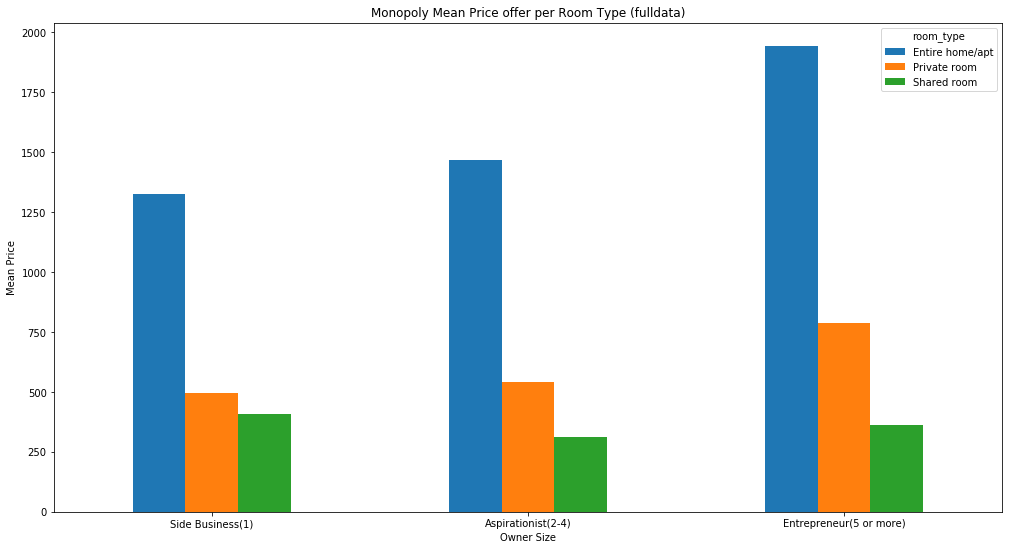

In [21]:
# Create a DataFrame for mean price per room type and MarketSize
Monopolyrooms = data_df.groupby(["MonopolySize", "room_type"])["price"].mean().unstack()

# Bar plot the DataFrame
Monopolyrooms.plot(kind = "bar", figsize = (17,9))

# Add title and labels
plt.title("Monopoly Mean Price offer per Room Type (fulldata)")
plt.xlabel("Owner Size")
plt.ylabel("Mean Price")

# Rotate x names
plt.xticks(rotation = 0)

# Display the plot
plt.show()


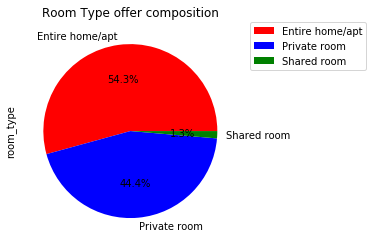

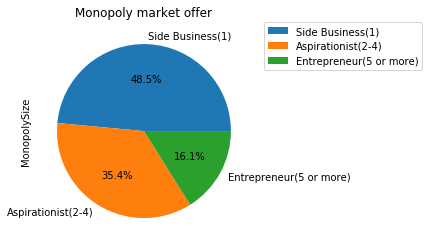

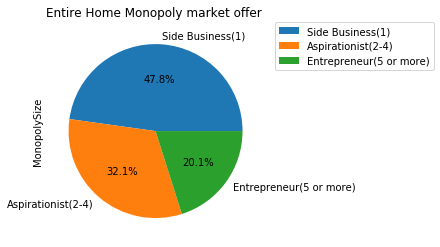

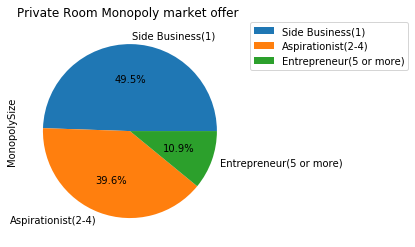

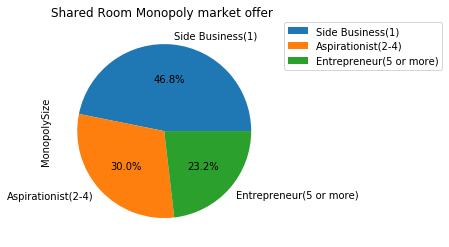

In [22]:
Kindoffer = data_df['room_type'].value_counts().to_frame()
Marketcompound = data_df['MonopolySize'].value_counts().to_frame()
Home = data_df.loc[data_df['room_type'] == 'Entire home/apt']['MonopolySize'].value_counts().to_frame()
Private = data_df.loc[data_df['room_type'] == 'Private room']['MonopolySize'].value_counts().to_frame()
Shared = data_df.loc[data_df['room_type'] == 'Shared room']['MonopolySize'].value_counts().to_frame()

Kindoffer.plot(kind='pie', subplots=True, autopct='%1.1f%%', colors = ['red', 'blue', 'green'])
plt.title('Room Type offer composition')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

Marketcompound.plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Monopoly market offer')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


Home.plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Entire Home Monopoly market offer ')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


Private.plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Private Room Monopoly market offer ')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

Shared.plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Shared Room Monopoly market offer ')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
